In [ ]:

import numpy as np
import mne
import os
import glob
import matplotlib.pyplot as plt
from scipy.signal import welch
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from tqdm.tqdm import tqdm 
import pandas as pd


# --- CONFIG ---
BASE_PATH = "Data_sub01"  # Adjust to your actual path
SAVE_PATH = "Augmented_Data_EEG_01"
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

In [2]:
def load_eeg_data(subject_id="sub-01", task="words"):
    """Loads MNE Epochs and returns data, labels, and sfreq."""
    eeg_dir = os.path.join(BASE_PATH, "Async_data_preproc_new", subject_id, "ses-eeg", "eeg")
    search_pattern = os.path.join(eeg_dir, f"*{subject_id}*desc-{task}_epo.fif")
    
    files = glob.glob(search_pattern)
    if not files:
        raise FileNotFoundError(f"No files found for {subject_id} task {task}")
        
    print(f"Loading: {files[0]}")
    epochs = mne.read_epochs(files[0], preload=True, verbose=False)
    
    # Return: X (Data), y (Labels), Sampling Freq
    return epochs.get_data(copy=True), epochs.events[:, -1], epochs.info['sfreq']

In [3]:
# 1. TIME DOMAIN (Slicing) -> REPLACES Original Data
def aug_time_window_slicing(X, y, sfreq, crop_len=1.5, stride=0.5):
    print(f"Applying Time Augmentation (Slicing)...")
    n_epochs, n_ch, n_time = X.shape
    win_samples = int(crop_len * sfreq)
    stride_samples = int(stride * sfreq)
    
    X_new, y_new = [], []
    
    # Validation
    if win_samples > n_time:
        print("WARNING: Crop length > Trial length. Returning original.")
        return X, y
    
    start_indices = range(0, n_time - win_samples + 1, stride_samples)
    
    for i in range(n_epochs):
        for start in start_indices:
            crop = X[i, :, start : start + win_samples]
            X_new.append(crop)
            y_new.append(y[i])
            
    return np.array(X_new), np.array(y_new)

# 2. FREQUENCY DOMAIN (Surrogate) -> ADDS to Original Data
def aug_freq_ft_surrogate(X, y, phase_noise_magnitude=0.5):
    print(f"Applying Frequency Augmentation (Surrogate)...")
    X_new = np.zeros_like(X)
    
    for i in range(len(X)):
        for ch in range(X.shape[1]):
            # RFFT (Real FFT only positive freqs)
            f_pos = np.fft.rfft(X[i, ch, :])
            
            # Mask low power freqs to avoid "shelf" noise artifact
            magnitudes = np.abs(f_pos)
            max_mag = np.max(magnitudes)
            mask = magnitudes > (0.001 * max_mag)
            
            # Random Phase Shift
            rand_phase = np.random.uniform(-np.pi, np.pi, len(f_pos)) * phase_noise_magnitude
            
            # Apply shift only to masked (active) frequencies
            rotator = np.ones(len(f_pos), dtype=complex)
            rotator[mask] = np.exp(1j * rand_phase[mask])
            rotator[0] = 1.0 # Keep DC constant
            
            f_shifted = f_pos * rotator
            X_new[i, ch, :] = np.fft.irfft(f_shifted, n=X.shape[2])
            
    # Concatenate: Original + Augmented
    return np.concatenate([X, X_new]), np.concatenate([y, y])

# 3. SPATIAL DOMAIN (Shuffling) -> ADDS to Original Data
def aug_spatial_channel_shuffle(X, y, p=0.1):
    print(f"Applying Spatial Augmentation (Shuffling)...")
    X_new = X.copy()
    n_ch = X.shape[1]
    n_swap = int(n_ch * p)
    
    for i in range(len(X)):
        indices = np.random.choice(n_ch, n_swap, replace=False)
        shuffled_indices = np.random.permutation(indices)
        X_new[i, indices, :] = X_new[i, shuffled_indices, :]
        
    return np.concatenate([X, X_new]), np.concatenate([y, y])

In [4]:
def compute_band_power(X, sfreq):
    """Converts Raw Voltage -> Band Power (Alpha, Beta, etc.)"""
    # Delta, Theta, Alpha, Beta, Gamma
    bands = [(1, 4), (4, 8), (8, 13), (13, 30), (30, 45)]
    freqs, psd = welch(X, fs=sfreq, nperseg=int(sfreq), axis=-1)
    
    X_bands = []
    for fmin, fmax in bands:
        idx = np.logical_and(freqs >= fmin, freqs <= fmax)
        if np.sum(idx) == 0: continue
        band_power = np.mean(psd[:, :, idx], axis=-1)
        X_bands.append(band_power)
        
    return np.stack(X_bands, axis=-1).reshape(len(X), -1)

def evaluate_augmentation(name, X, y, sfreq, groups=None):
    # 1. Feature Extraction (Crucial for RF)
    X_feat = compute_band_power(X, sfreq)
    
    # 2. Pipeline (Scaler is vital here)
    clf = make_pipeline(StandardScaler(), 
                        RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42))
    
    # 3. Validation Strategy
    if groups is not None:
        cv = GroupKFold(n_splits=5)
        scores = cross_val_score(clf, X_feat, y, groups=groups, cv=cv, scoring='accuracy')
    else:
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_val_score(clf, X_feat, y, cv=cv, scoring='accuracy')
        
    return scores.mean(), scores.std()

In [30]:
# 1. Load Original
X_orig, y_orig, sfreq = load_eeg_data()
n_classes = len(np.unique(y_orig))
print(f"\nOriginal Data: {X_orig.shape}, Classes: {n_classes}")

# 2. Run Augmentations
# Time: Replaces data (Slicing)
X_time, y_time = aug_time_window_slicing(X_orig, y_orig, sfreq, crop_len=2, stride=1)

# Freq: Doubles data (Concatenates)
X_freq, y_freq = aug_freq_ft_surrogate(X_orig, y_orig, phase_noise_magnitude=1.0)

# Spatial: Doubles data (Concatenates)
X_spat, y_spat = aug_spatial_channel_shuffle(X_orig, y_orig, p=0.2)


Loading: Data_sub01\Async_data_preproc_new\sub-01\ses-eeg\eeg\sub-01_ses-eeg_task-innerspeech_desc-words_epo.fif

Original Data: (320, 64, 1537), Classes: 8
Applying Time Augmentation (Slicing)...
Applying Frequency Augmentation (Surrogate)...
Applying Spatial Augmentation (Shuffling)...


In [31]:
def verify_dataset(name, X, y):
    print(f"\n--- Checking {name} ---")
    
    # 1. SHAPE CHECK
    print(f"Shape: {X.shape}")
    print(f"Labels: {y.shape}")
    """
    # 2. INTEGRITY CHECK (Crucial!)
    if np.isnan(X).any():
        print(f"ALERT: Found {np.isnan(X).sum()} NaNs in data!")
    if np.isinf(X).any():
        print(f"ALERT: Found {np.isinf(X).sum()} Infs in data!")
    if np.all(X == 0):
        print(f"CRITICAL: Data is all ZEROS! Augmentation failed.")
        
    # 3. STATS
    print(f"Mean: {np.mean(X):.2e} | Std: {np.std(X):.2e} | Min: {np.min(X):.2e} | Max: {np.max(X):.2e}")
    
    # 4. CLASS BALANCE
    unique, counts = np.unique(y, return_counts=True)
    balance = dict(zip(unique, counts))
    print(f"Class Distribution: {balance}")
    
    # 5. LOGIC CHECK
    if name == "Original":
        global n_orig
        n_orig = len(y)
    elif name == "Time (Slicing)":
        expected_min = n_orig * 2  # Assuming at least 2 crops per trial
        if len(y) < expected_min:
            print(f"Warning: Dataset size {len(y)} seems small for slicing (Orig: {n_orig}). Check stride?")
    elif name in ["Freq (Surrogate)", "Spatial (Shuffle)"]:
        if len(y) != n_orig * 2:
            print(f"Error: Dataset size {len(y)} should be exactly 2x Original ({n_orig*2})")
    """

# --- RUN DIAGNOSTICS ---
verify_dataset("Original", X_orig, y_orig)
verify_dataset("Time (Slicing)", X_time, y_time)
verify_dataset("Freq (Surrogate)", X_freq, y_freq)
verify_dataset("Spatial (Shuffle)", X_spat, y_spat)


--- Checking Original ---
Shape: (320, 64, 1537)
Labels: (320,)

--- Checking Time (Slicing) ---
Shape: (640, 64, 1024)
Labels: (640,)

--- Checking Freq (Surrogate) ---
Shape: (640, 64, 1537)
Labels: (640,)

--- Checking Spatial (Shuffle) ---
Shape: (640, 64, 1537)
Labels: (640,)


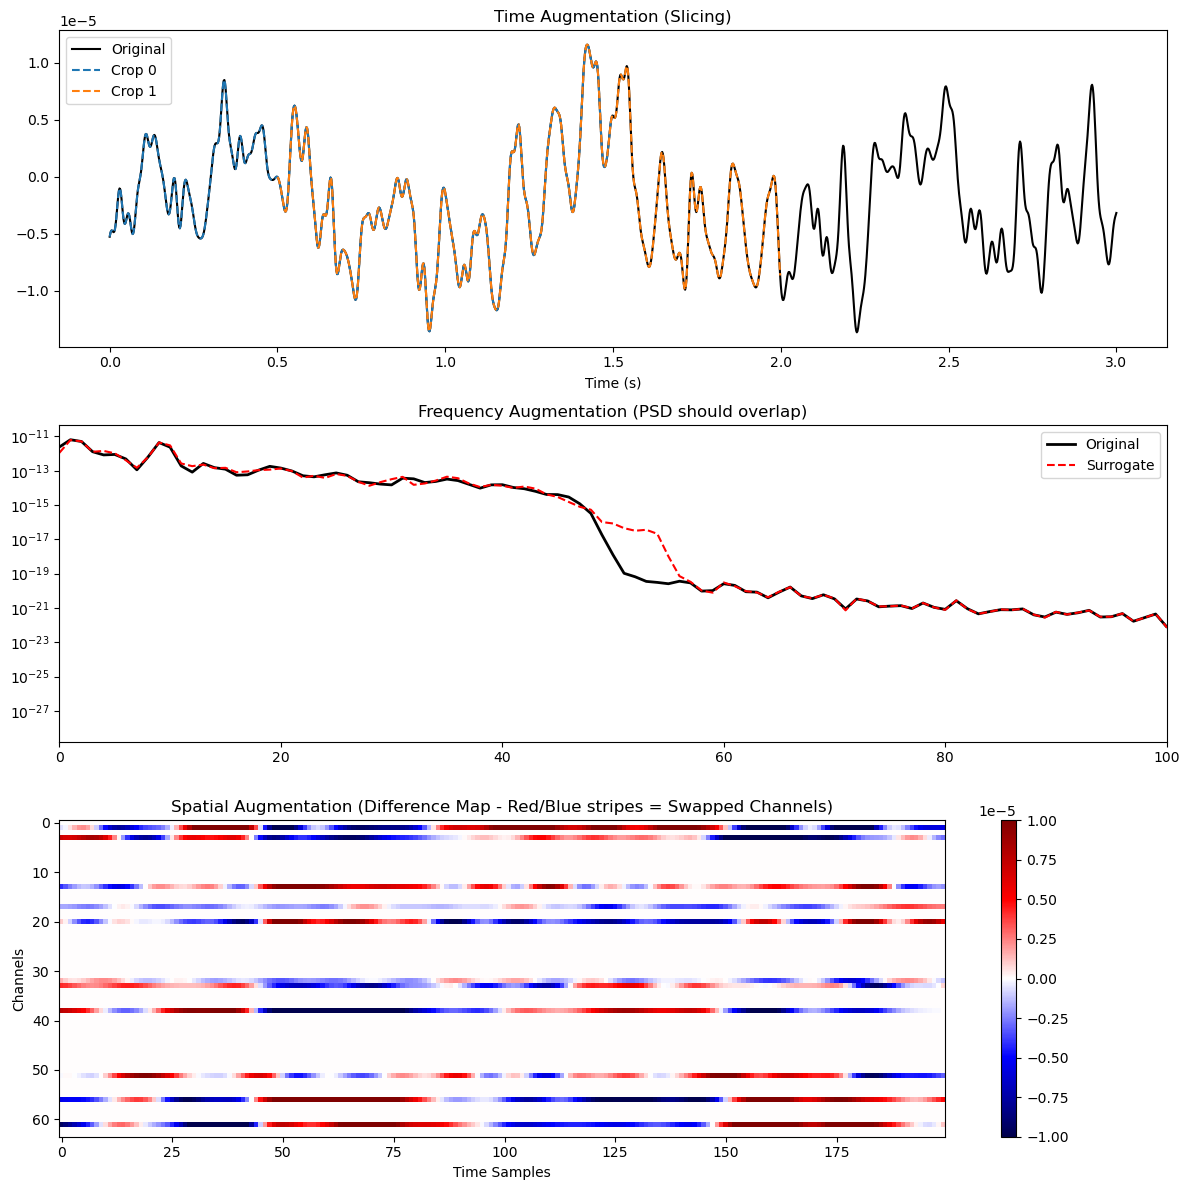

In [14]:
def plot_augmentations(X_orig, X_time, X_freq, X_spat, sfreq):
    trial_idx = 0
    ch_idx = 10
    
    # Since X_freq and X_spat are concatenated (Orig + Aug),
    # the augmented version of Trial 0 is at index N + 0.
    aug_idx = len(X_orig) + trial_idx 
    
    fig, axes = plt.subplots(3, 1, figsize=(12, 12))
    
    # 1. Time Slicing
    time = np.arange(X_orig.shape[2]) / sfreq
    axes[0].plot(time, X_orig[trial_idx, ch_idx], 'k', label='Original')
    
    # Plot first 2 crops (roughly estimated indices)
    # If 3 crops per trial, crop 0,1,2 belong to trial 0
    n_crops = len(X_time) // len(X_orig)
    for i in range(min(2, n_crops)):
        crop_idx = trial_idx * n_crops + i
        crop = X_time[crop_idx, ch_idx]
        # Shift time axis for display
        t_crop = np.arange(len(crop))/sfreq + (i*0.5)
        axes[0].plot(t_crop, crop, '--', label=f'Crop {i}')
        
    axes[0].set_title("Time Augmentation (Slicing)")
    axes[0].set_xlabel("Time (s)")
    axes[0].legend()
    
    # 2. Frequency Surrogate (PSD)
    # Check PSD of Original (Index 0) vs Augmented (Index N+0)
    f_orig, p_orig = welch(X_orig[trial_idx, ch_idx], fs=sfreq, nperseg=int(sfreq))
    f_aug, p_aug = welch(X_freq[aug_idx, ch_idx], fs=sfreq, nperseg=int(sfreq))
    
    axes[1].semilogy(f_orig, p_orig, 'k', linewidth=2, label='Original')
    axes[1].semilogy(f_aug, p_aug, 'r--', label='Surrogate')
    axes[1].set_title("Frequency Augmentation (PSD should overlap)")
    axes[1].set_xlim(0, 100)
    axes[1].legend()
    
    # 3. Spatial Shuffle (Diff)
    # Check Difference between Original (Index 0) and Augmented (Index N+0)
    # Using only first 200 samples for visibility
    vis_samples = 200
    diff = X_spat[aug_idx, :, :vis_samples] - X_orig[trial_idx, :, :vis_samples]
    
    im = axes[2].imshow(diff, aspect='auto', cmap='seismic', vmin=-1e-5, vmax=1e-5)
    axes[2].set_title("Spatial Augmentation (Difference Map - Red/Blue stripes = Swapped Channels)")
    axes[2].set_xlabel("Time Samples")
    axes[2].set_ylabel("Channels")
    plt.colorbar(im, ax=axes[2])
    
    plt.tight_layout()
    plt.show()

plot_augmentations(X_orig, X_time, X_freq, X_spat, sfreq)

In [ ]:

# 3. Evaluate & Save
datasets = {
    "Original": (X_orig, y_orig, "orig"),
    "Time": (X_time, y_time, "time"),
    "Freq": (X_freq, y_freq, "concat"),
    "Spatial": (X_spat, y_spat, "concat")
}

print(f"\n{'DATASET':<15} | {'ACCURACY':<10} | {'STD':<10} | {'SHAPE'}")
print("-" * 60)

for name, (X, y, mode) in datasets.items():
    # Save
    np.save(os.path.join(SAVE_PATH, f"X_eeg_{name.lower()}.npy"), X)
    np.save(os.path.join(SAVE_PATH, f"y_eeg_{name.lower()}.npy"), y)
    
    # Grouping Logic for Validation
    n_orig_trials = len(y_orig)
    if mode == "orig":
        groups = None # Simple StratifiedKFold
    elif mode == "concat":
        # Groups [0..79, 0..79]
        groups = np.concatenate([np.arange(n_orig_trials), np.arange(n_orig_trials)])
    elif mode == "time":
        # Groups [0,0,0, 1,1,1...]
        n_crops = len(y) // n_orig_trials
        groups = np.repeat(np.arange(n_orig_trials), n_crops)[:len(y)]

    # Evaluate
    acc, std = evaluate_augmentation(name, X, y, sfreq, groups)
    print(f"{name:<15} | {acc:.2%}     | +/-{std:.2%} | {X.shape}")




DATASET         | ACCURACY   | STD        | SHAPE
------------------------------------------------------------
Original        | 14.69%     | +/-3.37% | (320, 64, 1537)
Time            | 10.94%     | +/-3.19% | (1280, 64, 768)
Freq            | 12.50%     | +/-4.56% | (640, 64, 1537)
Spatial         | 12.97%     | +/-3.58% | (640, 64, 1537)


In [15]:
# --- CONFIG ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
from tqdm.notebook import tqdm

BATCH_SIZE = 16
EPOCHS = 50
LEARNING_RATE = 0.001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# ==========================================
# 1. EEGNet ARCHITECTURE
# ==========================================
class EEGNet(nn.Module):
    def __init__(self, nb_classes, Chans=64, Samples=128, 
                 dropoutRate=0.5, kernLength=64, F1=8, D=2, F2=16):
        super(EEGNet, self).__init__()
        
        # Block 1: Temporal Conv
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, F1, (1, kernLength), padding=(0, kernLength//2), bias=False),
            nn.BatchNorm2d(F1, False)
        )
        
        # Block 2: Spatial Filter (Depthwise)
        self.conv2 = nn.Sequential(
            nn.Conv2d(F1, D*F1, (Chans, 1), groups=F1, bias=False),
            nn.BatchNorm2d(D*F1, False),
            nn.ELU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(dropoutRate)
        )
        
        # Block 3: Separable Conv
        self.conv3 = nn.Sequential(
            nn.Conv2d(D*F1, D*F1, (1, 16), padding=(0, 8), groups=D*F1, bias=False),
            nn.Conv2d(D*F1, F2, (1, 1), bias=False),
            nn.BatchNorm2d(F2, False),
            nn.ELU(),
            nn.AvgPool2d((1, 8)),
            nn.Dropout(dropoutRate)
        )
        
        # Calculate Flatten Size dynamically
        self.flatten_dim = F2 * (Samples // 32)
        self.classifier = nn.Linear(self.flatten_dim, nb_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
# ==========================================
# 2. PREP DATA (In-Memory)
# ==========================================
def prep_data_tensor(X, y):
    # 1. Encode Labels (e.g. 111 -> 0)
    le = LabelEncoder()
    y_enc = le.fit_transform(y)
    n_classes = len(le.classes_)
    
    # 2. Scale Data (Mean=0, Std=1)
    # Reshape to (N, Features) for scaler
    N, Ch, T = X.shape
    X_flat = X.reshape(N, -1)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_flat)
    
    # Reshape to (N, 1, Ch, T) for Conv2d
    X_final = X_scaled.reshape(N, 1, Ch, T)
    
    # 3. To Tensor
    X_tensor = torch.FloatTensor(X_final)
    y_tensor = torch.LongTensor(y_enc)
    
    return X_tensor, y_tensor, n_classes

Using device: cuda


In [20]:
from tqdm import tqdm
def run_training(name, X_raw, y_raw):
    print(f"\n=== Training on {name} Data ===")
    
    # Prep
    X, y, n_classes = prep_data_tensor(X_raw, y_raw)
    _, _, n_chans, n_samples = X.shape
    
    # 5-Fold CV
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    acc_scores = []
    
    # Iterate through folds
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        # Split
        X_train, y_train = X[train_idx].to(DEVICE), y[train_idx].to(DEVICE)
        X_val, y_val = X[val_idx].to(DEVICE), y[val_idx].to(DEVICE)
        
        # Loader
        train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False)
        
        # Init Model
        model = EEGNet(nb_classes=n_classes, Chans=n_chans, Samples=n_samples).to(DEVICE)
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
        criterion = nn.CrossEntropyLoss()
        
        # Train Loop with Progress Bar
        # leave=False keeps the notebook clean (removes bar after completion)
        with tqdm(total=EPOCHS, desc=f"Fold {fold+1}", leave=False) as pbar:
            for epoch in range(EPOCHS):
                model.train()
                train_loss = 0
                for inputs, targets in train_loader:
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    loss.backward()
                    optimizer.step()
                    train_loss += loss.item()
                
                # Update progress bar with loss
                pbar.set_postfix({'loss': train_loss / len(train_loader)})
                pbar.update(1)
        
        # Validation after all epochs
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
        
        acc = correct / total
        acc_scores.append(acc)
        print(f"Fold {fold+1}: {acc:.2%}")
        
    print(f"--> {name} Mean Accuracy: {np.mean(acc_scores):.2%} (+/- {np.std(acc_scores):.2%})")

In [32]:
import os
import numpy as np

# --- CONFIG ---
SAVE_DIR = "Augmented_Data_EEG_01"
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

print(f"Saving data to: {os.path.abspath(SAVE_DIR)}\n")

# --- LIST OF DATASETS ---
# Ensure these variables exist in your environment
my_datasets = [
    ("Original", X_orig, y_orig),
    ("Time_Slicing", X_time, y_time),     # Removed spaces for safer filenames
    ("Freq_Surrogate", X_freq, y_freq),
    ("Spatial_Shuffle", X_spat, y_spat)
]

# --- SAVE LOOP ---
for name, X_d, y_d in my_datasets:
    # Construct filenames
    x_path = os.path.join(SAVE_DIR, f"X_{name}.npy")
    y_path = os.path.join(SAVE_DIR, f"y_{name}.npy")
    
    # Save
    np.save(x_path, X_d)
    np.save(y_path, y_d)
    
    print(f"✅ Saved {name}:")
    print(f"   X -> {x_path} {X_d.shape}")
    print(f"   Y -> {y_path} {y_d.shape}")

print("\nAll datasets saved successfully! Zip this folder and upload to your cluster.")

Saving data to: d:\OneDrive - Luleå University of Technology\År 5\EX\Augmented_Data_EEG_01

✅ Saved Original:
   X -> Augmented_Data_EEG_01\X_Original.npy (320, 64, 1537)
   Y -> Augmented_Data_EEG_01\y_Original.npy (320,)
✅ Saved Time_Slicing:
   X -> Augmented_Data_EEG_01\X_Time_Slicing.npy (640, 64, 1024)
   Y -> Augmented_Data_EEG_01\y_Time_Slicing.npy (640,)
✅ Saved Freq_Surrogate:
   X -> Augmented_Data_EEG_01\X_Freq_Surrogate.npy (640, 64, 1537)
   Y -> Augmented_Data_EEG_01\y_Freq_Surrogate.npy (640,)
✅ Saved Spatial_Shuffle:
   X -> Augmented_Data_EEG_01\X_Spatial_Shuffle.npy (640, 64, 1537)
   Y -> Augmented_Data_EEG_01\y_Spatial_Shuffle.npy (640,)

All datasets saved successfully! Zip this folder and upload to your cluster.


In [21]:
my_datasets = [
    ("Original", X_orig, y_orig),
    ("Time Slicing", X_time, y_time),
    ("Freq Surrogate", X_freq, y_freq),
    ("Spatial Shuffle", X_spat, y_spat)
]

for name, X_d, y_d in my_datasets:
    try:
        run_training(name, X_d, y_d)
    except Exception as e:
        print(f"Failed on {name}: {e}")


=== Training on Original Data ===


Fold 1: 20.31%


Fold 2: 23.44%


Fold 3: 12.50%


Fold 4: 20.31%


Fold 5: 21.88%
--> Original Mean Accuracy: 19.69% (+/- 3.78%)

=== Training on Time Slicing Data ===


KeyboardInterrupt: 

Dataset              | Shape                | Mean       | Std        | Min        | Max       
-----------------------------------------------------------------------------------------------
Original             | (320, 64, 1537)      | -1.99e-07   | 9.56e-06   | -0.00     | 0.00
Time_Slicing         | (2880, 64, 716)      | -1.55e-07   | 9.69e-06   | -0.00     | 0.00
Freq_Surrogate       | (2880, 64, 1537)     | -1.99e-07   | 9.56e-06   | -0.00     | 0.00
Spatial_Shuffle      | (2880, 64, 1537)     | -1.99e-07   | 9.56e-06   | -0.00     | 0.00

Generating comparison plots...


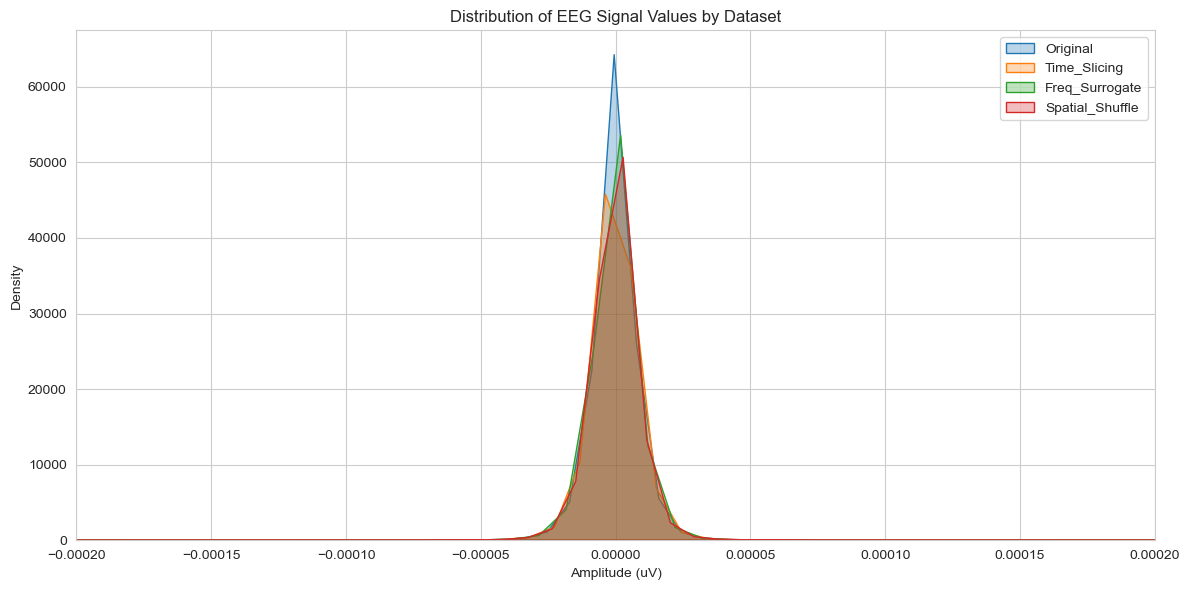

<Figure size 1200x600 with 0 Axes>

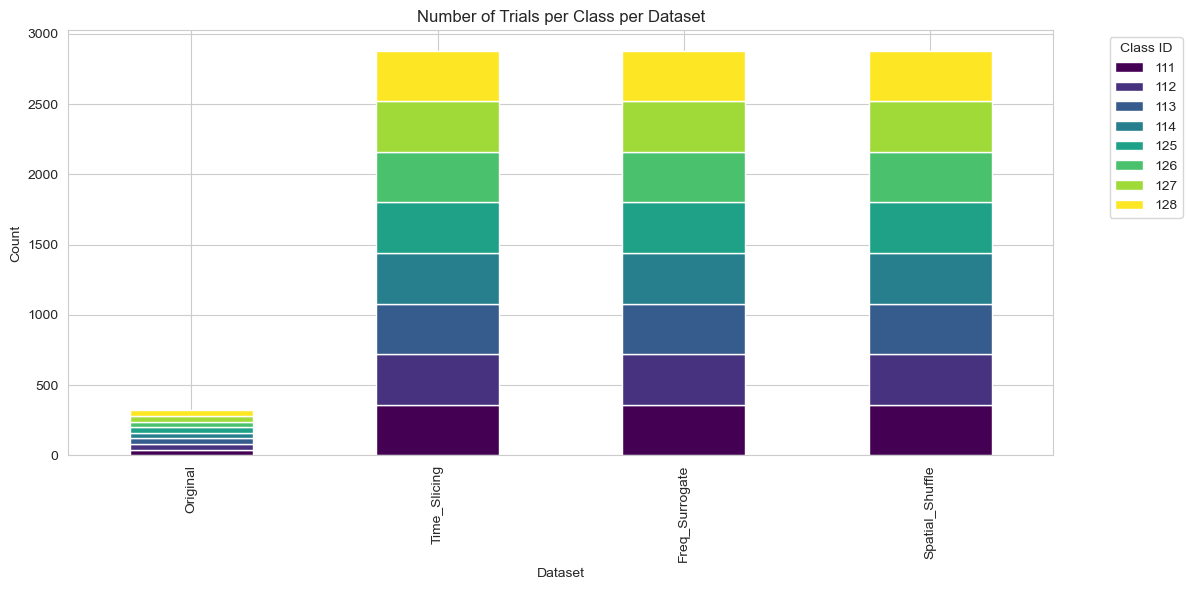

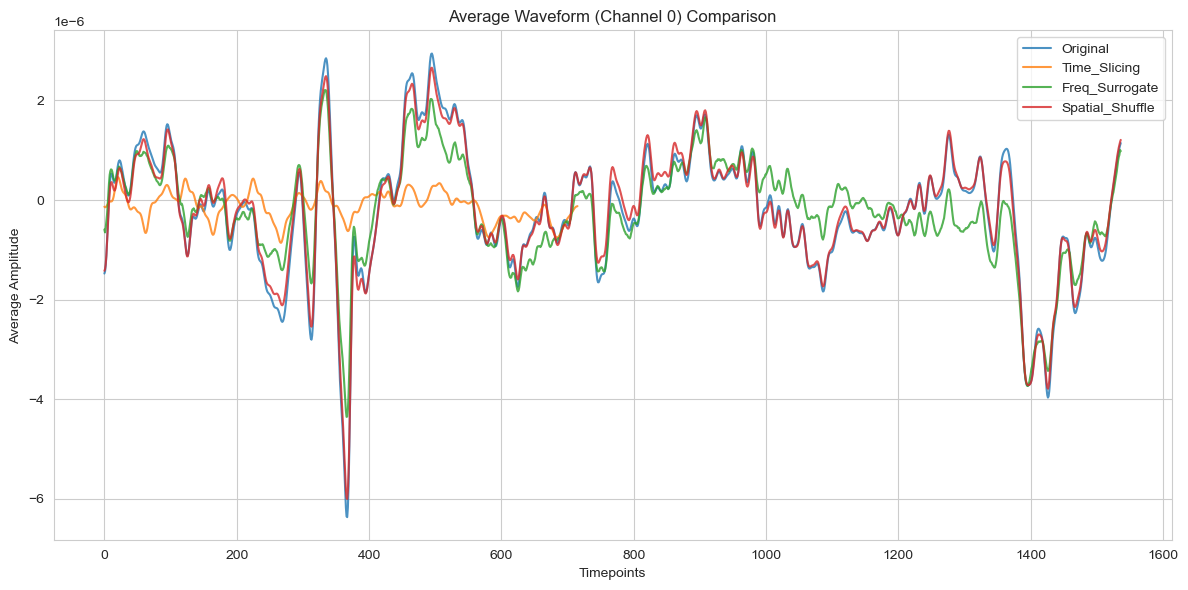


Done! Check the 'Augmented_Data_EEG' folder for images.


In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# ==========================================
# CONFIGURATION
# ==========================================
DATA_DIR = "Augmented_Data_EEG_01"
datasets = ["Original", "Time_Slicing", "Freq_Surrogate", "Spatial_Shuffle"]

# ==========================================
# 1. LOAD AND COMPUTE STATS
# ==========================================
stats_list = []
all_data = {} # To store a sample for plotting

print(f"{'Dataset':<20} | {'Shape':<20} | {'Mean':<10} | {'Std':<10} | {'Min':<10} | {'Max':<10}")
print("-" * 95)

for name in datasets:
    x_path = os.path.join(DATA_DIR, f"X_{name}.npy")
    y_path = os.path.join(DATA_DIR, f"y_{name}.npy")
    
    if not os.path.exists(x_path):
        print(f"Skipping {name} (File not found)")
        continue

    X = np.load(x_path)
    y = np.load(y_path)
    
    # Compute Global Statistics
    mean_val = np.mean(X)
    std_val = np.std(X)
    min_val = np.min(X)
    max_val = np.max(X)
    
    # Store for Table
    stats_list.append({
        "Dataset": name,
        "Trials": X.shape[0],
        "Timepoints": X.shape[2],
        "Mean": mean_val,
        "Std": std_val,
        "Min": min_val,
        "Max": max_val
    })
    
    # Store a flattened sample for Histogram plotting (downsample for speed)
    # Taking a random 5% sample to keep plotting fast
    flat_data = X.flatten()
    sample_size = int(len(flat_data) * 0.05)
    all_data[name] = np.random.choice(flat_data, sample_size, replace=False)
    
    print(f"{name:<20} | {str(X.shape):<20} | {mean_val:.2e}   | {std_val:.2e}   | {min_val:.2f}     | {max_val:.2f}")

# ==========================================
# 2. GENERATE COMPARISON PLOTS
# ==========================================
print("\nGenerating comparison plots...")

# Set clearer style
sns.set_style("whitegrid")

# --- PLOT 1: Value Distributions (Histograms) ---
plt.figure(figsize=(12, 6))
for name, data in all_data.items():
    sns.kdeplot(data, label=name, fill=True, alpha=0.3)

plt.title("Distribution of EEG Signal Values by Dataset")
plt.xlabel("Amplitude (uV)")
plt.ylabel("Density")
plt.legend()
plt.xlim(-0.0002, 0.0002) # Adjust based on your data scale (likely very small if in Volts)
# Note: If your data is standardized (approx -3 to 3), remove the xlim or adjust it.
plt.tight_layout()
plt.show()
# --- PLOT 2: Class Balance ---
class_counts = {}
for name in datasets:
    y_path = os.path.join(DATA_DIR, f"y_{name}.npy")
    if os.path.exists(y_path):
        y = np.load(y_path)
        unique, counts = np.unique(y, return_counts=True)
        # Create dictionary for pandas
        counts_dict = dict(zip(unique, counts))
        class_counts[name] = counts_dict

# Convert to DataFrame for easier plotting
df_counts = pd.DataFrame(class_counts).T
df_counts = df_counts.fillna(0)

plt.figure(figsize=(12, 6))
df_counts.plot(kind='bar', stacked=True, colormap='viridis', figsize=(12, 6))
plt.title("Number of Trials per Class per Dataset")
plt.xlabel("Dataset")
plt.ylabel("Count")
plt.legend(title="Class ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
# --- PLOT 3: Average Waveform (Channel 0) ---
# Compares the "Average Trial" of Channel 0 across datasets to see if structure is preserved
plt.figure(figsize=(12, 6))
for name in datasets:
    x_path = os.path.join(DATA_DIR, f"X_{name}.npy")
    if os.path.exists(x_path):
        X = np.load(x_path)
        # Mean across all trials, Channel 0
        # Check if dimensions match. Time slicing will be shorter.
        time_axis = np.arange(X.shape[2])
        mean_waveform = np.mean(X[:, 0, :], axis=0) # Channel 0
        
        plt.plot(time_axis, mean_waveform, label=name, alpha=0.8)

plt.title("Average Waveform (Channel 0) Comparison")
plt.xlabel("Timepoints")
plt.ylabel("Average Amplitude")
plt.legend()
plt.tight_layout()
plt.show()
print("\nDone! Check the 'Augmented_Data_EEG' folder for images.")